In [ ]:
import csv
import time
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# --- Bagian 1: Persiapan Selenium ---
print("Menginisialisasi browser Chrome...")
driver = None  # Initialize driver to None
try:
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
except Exception as e:
    print(f"Gagal memulai Selenium WebDriver: {e}")
    # Do not exit, allow the script to continue and handle the case where driver is None

url = 'https://www.imdb.com/title/tt15398776/reviews/'
output_filename = 'oppenheimer_reviews_final.csv'

if driver: # Only proceed if driver was successfully initialized
    print(f"Membuka halaman: {url}")
    driver.get(url)

    # --- Bagian 2: Menggunakan Explicit Wait (Cara yang lebih baik) ---
    try:
        # Selector untuk kontainer review (sesuai dengan struktur di selenium_debug.html)
        # review items ada sebagai <article class="... user-review-item">
        review_container_selector = (By.CSS_SELECTOR, 'article.user-review-item')

        print("Menunggu kontainer review muncul di halaman (maksimal 20 detik)...")
        # Tunggu sampai setidaknya satu atau beberapa review (article.user-review-item) ada di DOM
        WebDriverWait(driver, 20).until(
            EC.presence_of_all_elements_located(review_container_selector)
        )
        print("Kontainer review berhasil ditemukan.")

        # Coba ambil jumlah total review (elemen yang menampilkan "4,507 reviews")
        total_reviews = None
        try:
            total_text_el = driver.find_element(By.CSS_SELECTOR, '[data-testid="tturv-total-reviews"]')
            total_text = total_text_el.text
            m = re.search(r"([0-9,]+)", total_text)
            if m:
                total_reviews = int(m.group(1).replace(',', ''))
                print(f"Total reviews terdeteksi: {total_reviews}")
        except Exception:
            # Kalau gagal ambil total, lanjutkan dengan klik sampai tombol hilang
            pass

        # Loop untuk menekan tombol "25 more" / "See all" sampai semua review dimuat
        reviews_selector = 'article.user-review-item'
        prev_count = len(driver.find_elements(By.CSS_SELECTOR, reviews_selector))
        print(f"Jumlah review saat ini: {prev_count}")

        max_iterations = 1000
        iteration = 0
        while True:
            iteration += 1
            if iteration > max_iterations:
                print("Mencapai batas iterasi maksimum. Hentikan proses load-more.")
                break

            # Jika kita tahu total_reviews dan sudah terpenuhi, berhenti
            if total_reviews is not None and prev_count >= total_reviews:
                print("All reviews loaded based on total count.")
                break


            # Cari tombol di area pagination
            try:
                pagination_buttons = driver.find_elements(By.CSS_SELECTOR, 'div[data-testid="tturv-pagination"] button.ipc-see-more__button')
            except Exception:
                pagination_buttons = []

            btn_to_click = None
            for btn in pagination_buttons:
                try:
                    if btn.is_displayed() and btn.is_enabled():
                        btn_to_click = btn
                        break
                except Exception:
                    continue

            if not btn_to_click:
                print("Tidak menemukan tombol 'See more' / '25 more' lagi. Berhenti.")
                break

            try:
                print(f"Menekan tombol load-more (iterasi {iteration})...")
                driver.execute_script("arguments[0].click();", btn_to_click)

                # Tunggu jumlah artikel meningkat
                try:
                    WebDriverWait(driver, 15).until(
                        lambda d: len(d.find_elements(By.CSS_SELECTOR, reviews_selector)) > prev_count
                    )
                except Exception:
                    # jika tidak bertambah, hentikan agar tidak loop tak terbatas
                    print("Tombol diklik tetapi tidak ada review baru yang muncul dalam 15 detik. Berhenti.")
                    break

                # update prev_count
                new_count = len(driver.find_elements(By.CSS_SELECTOR, reviews_selector))
                print(f"Jumlah review bertambah: {prev_count} -> {new_count}")
                prev_count = new_count

                # singkat jeda agar tidak terlalu agresif
                time.sleep(0.6)

            except Exception as e:
                print(f"Gagal menekan tombol load-more: {e}")
                break

        # Ambil source code setelah pemuatan dinamis selesai
        page_source = driver.page_source

    except Exception as e:
        print(f"Gagal menunggu elemen muncul atau elemen tidak ditemukan: {e}")
        page_source = driver.page_source # Tetap coba ambil source, mungkin berguna untuk debug

    finally:
        driver.quit() # Selalu tutup browser
        print("Browser telah ditutup.")

else: # If driver was not initialized, set page_source to empty string
    page_source = ""
    print("WebDriver was not initialized, skipping dynamic content loading.")


# --- Bagian 3: Parsing dengan BeautifulSoup dan Selector BARU ---
soup = BeautifulSoup(page_source, 'html.parser')

# Menggunakan selector yang sesuai dengan struktur terkini (article.user-review-item)
review_containers = soup.find_all('article', class_='user-review-item')

print(f"Ditemukan {len(review_containers)} review. Memproses...")
if not review_containers and page_source: # Also check if page_source is not empty
    print("Gagal menemukan kontainer. Silakan periksa file 'selenium_debug.html' (jika dibuat).")
    # Simpan HTML untuk debug jika gagal
    with open('selenium_debug.html', 'w', encoding='utf-8') as f:
        f.write(soup.prettify())
    # Do not exit, continue to write an empty or header-only CSV/Excel
elif not page_source:
    print("Page source is empty, cannot parse reviews.")


# --- Bagian 4: Kumpulkan baris dan tulis ke CSV dan Excel ---
rows = []
header = ['Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title', 'Review_Text']
rows.append(header)

if review_containers: # Only process and write rows if review_containers were found
    for container in review_containers:
        try:
            # Reviewer name (data-testid="author-link")
            reviewer_tag = container.find('a', attrs={'data-testid': 'author-link'})
            reviewer_name = reviewer_tag.get_text(strip=True) if reviewer_tag else 'N/A'

            # Review date (li with class 'review-date')
            review_date_tag = container.find('li', class_='review-date')
            review_date = review_date_tag.get_text(strip=True) if review_date_tag else 'N/A'

            # Rating: span.ipc-rating-star--rating inside the review block
            rating_tag = container.find('span', class_='ipc-rating-star--rating')
            rating = rating_tag.get_text(strip=True) if rating_tag else 'N/A'

            # Review title: h3.ipc-title__text (inside data-testid="review-summary")
            title_tag = container.find('h3', class_='ipc-title__text')
            review_title = title_tag.get_text(strip=True) if title_tag else 'N/A'

            # Review text: element with data-testid="review-overflow" (fallback to any long text div)
            review_text_tag = container.find(attrs={'data-testid': 'review-overflow'})
            if not review_text_tag:
                # try common class used for overflow text
                review_text_tag = container.find('div', class_='ipc-overflowText')
            review_text = review_text_tag.get_text(separator='\n', strip=True) if review_text_tag else 'N/A'

            rows.append([reviewer_name, review_date, rating, review_title, review_text])
        except Exception as e:
            # If one review parsing fails, continue with next and log the issue
            print(f"Gagal mem-parsing satu review: {e}")

# Tulis CSV seperti sebelumnya
with open(output_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

print(f"\nSelesai! Data review telah berhasil ditulis ke file {output_filename}")

# Tulis juga ke Excel (.xlsx) jika openpyxl tersedia; jika tidak, beri instruksi instalasi
excel_filename = 'oppenheimer_reviews_final.xlsx'
try:
    from openpyxl import Workbook

    wb = Workbook()
    ws = wb.active
    for r in rows:
        ws.append(r)
    wb.save(excel_filename)
    print(f"Excel berhasil dibuat: {excel_filename}")
except Exception as e:
    print(f"Tidak dapat menulis Excel: {e}")
    print("openpyxl mungkin belum terinstal. Jika Anda ingin, saya bisa menginstalnya dan menjalankan skrip lagi.")

Menginisialisasi browser Chrome...
Gagal memulai Selenium WebDriver: Message: unknown error: cannot find Chrome binary
Stacktrace:
#0 0x5d27d96094e3 <unknown>
#1 0x5d27d9338c76 <unknown>
#2 0x5d27d935f757 <unknown>
#3 0x5d27d935e029 <unknown>
#4 0x5d27d939cccc <unknown>
#5 0x5d27d939c47f <unknown>
#6 0x5d27d9393de3 <unknown>
#7 0x5d27d93692dd <unknown>
#8 0x5d27d936a34e <unknown>
#9 0x5d27d95c93e4 <unknown>
#10 0x5d27d95cd3d7 <unknown>
#11 0x5d27d95d7b20 <unknown>
#12 0x5d27d95ce023 <unknown>
#13 0x5d27d959c1aa <unknown>
#14 0x5d27d95f26b8 <unknown>
#15 0x5d27d95f2847 <unknown>
#16 0x5d27d9602243 <unknown>
#17 0x7fe242d2cac3 <unknown>

WebDriver was not initialized, skipping dynamic content loading.
Ditemukan 0 review. Memproses...
Page source is empty, cannot parse reviews.

Selesai! Data review telah berhasil ditulis ke file oppenheimer_reviews_final.csv
Excel berhasil dibuat: oppenheimer_reviews_final.xlsx


In [ ]:
!pip install requests beautifulsoup4 lxml pandas

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

BASE_URL = "https://www.imdb.com/chart/moviemeter/"

headers = {
    "User-Agent": "Mozilla/5.0"
}

def get_movies():
    response = requests.get(BASE_URL, headers=headers)
    soup = BeautifulSoup(response.text, "lxml")

    movies = []

    for item in soup.select("tbody tr")[:20]:  # Ambil 20 film teratas
        title_el = item.select_one(".ipc-title-link-wrapper a")
        rating_el = item.select_one(".ipc-rating-star--rating")

        if title_el:
            title = title_el.text.strip()
            url = "https://www.imdb.com" + title_el["href"].split("?")[0]
        else:
            continue

        rating = rating_el.text.strip() if rating_el else "N/A"

        # Ambil tahun rilis jika ada
        year_el = item.select_one(".sc-1eb68c7-8")
        year = year_el.text.strip() if year_el else "N/A"

        movies.append([title, year, rating, url])
        print(f"Scraped: {title}")

        time.sleep(1)

    return movies


# Jalankan scraping
data = get_movies()

# Simpan ke CSV
df = pd.DataFrame(data, columns=["Title", "Year", "Rating", "URL"])
df.to_csv("imdb_movies.csv", index=False, encoding="utf-8-sig")

print("\n✅ Selesai! Data berhasil disimpan → imdb_movies.csv")
df.head()



✅ Selesai! Data berhasil disimpan → imdb_movies.csv


,Title,Year,Rating,URL


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import csv # Import the csv module

# --- Bagian 1: Persiapan URL dan Header ---
url = 'https://www.imdb.com/title/tt15398776/reviews/'
output_filename_csv = 'oppenheimer_reviews_requests.csv'
output_filename_excel = 'oppenheimer_reviews_requests.xlsx'

# Menggunakan header untuk mensimulasikan browser agar tidak diblokir
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# --- Bagian 2: Mengambil Konten Halaman dengan requests ---
print(f"Mengambil konten halaman: {url}")
try:
    response = requests.get(url, headers=headers)
    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
    page_source = response.text
    print("Konten halaman berhasil diambil.")
except requests.exceptions.RequestException as e:
    print(f"Gagal mengambil konten halaman: {e}")
    page_source = "" # Set page_source to empty string if fetching fails

# --- Bagian 3: Parsing dengan BeautifulSoup ---
soup = BeautifulSoup(page_source, 'html.parser')

# Menggunakan selector yang sesuai dengan struktur terkini (article.user-review-item)
# Perhatikan bahwa dengan requests, kita hanya mendapatkan HTML statis.
# Jika review dimuat secara dinamis oleh JavaScript, ini hanya akan mendapatkan review awal.
review_containers = soup.find_all('article', class_='user-review-item')

print(f"Ditemukan {len(review_containers)} review. Memproses...")
if not review_containers and page_source:
    print("Gagal menemukan kontainer review. Ini mungkin karena review dimuat secara dinamis oleh JavaScript.")
elif not page_source:
     print("Tidak ada sumber halaman untuk diparsing.")


# --- Bagian 4: Kumpulkan baris dan tulis ke CSV dan Excel ---
rows = []
header = ['Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title', 'Review_Text']
rows.append(header)

if review_containers: # Only process and write rows if review_containers were found
    for container in review_containers:
        try:
            # Reviewer name (data-testid="author-link")
            reviewer_tag = container.find('a', attrs={'data-testid': 'author-link'})
            reviewer_name = reviewer_tag.get_text(strip=True) if reviewer_tag else 'N/A'

            # Review date (li with class 'review-date')
            review_date_tag = container.find('li', class_='review-date')
            review_date = review_date_tag.get_text(strip=True) if review_date_tag else 'N/A'

            # Rating: span.ipc-rating-star--rating inside the review block
            rating_tag = container.find('span', class_='ipc-rating-star--rating')
            rating = rating_tag.get_text(strip=True) if rating_tag else 'N/A'

            # Review title: h3.ipc-title__text (inside data-testid="review-summary")
            title_tag = container.find('h3', class_='ipc-title__text')
            review_title = title_tag.get_text(strip=True) if title_tag else 'N/A'

            # Review text: element with data-testid="review-overflow" (fallback to any long text div)
            review_text_tag = container.find(attrs={'data-testid': 'review-overflow'})
            if not review_text_tag:
                # try common class used for overflow text
                review_text_tag = container.find('div', class_='ipc-overflowText')
            review_text = review_text_tag.get_text(separator='\n', strip=True) if review_text_tag else 'N/A'

            rows.append([reviewer_name, review_date, rating, review_title, review_text])
        except Exception as e:
            # If one review parsing fails, continue with next and log the issue
            print(f"Gagal mem-parsing satu review: {e}")

# Tulis CSV seperti sebelumnya
with open(output_filename_csv, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

print(f"\nSelesai! Data review telah berhasil ditulis ke file {output_filename_csv}")

# Tulis juga ke Excel (.xlsx) jika openpyxl tersedia; jika tidak, beri instruksi instalasi
try:
    from openpyxl import Workbook

    wb = Workbook()
    ws = wb.active
    for r in rows:
        ws.append(r)
    wb.save(output_filename_excel)
    print(f"Excel berhasil dibuat: {output_filename_excel}")
except Exception as e:
    print(f"Tidak dapat menulis Excel: {e}")
    print("openpyxl mungkin belum terinstal. Jika Anda ingin, saya bisa menginstalnya dan menjalankan skrip lagi.")

Mengambil konten halaman: https://www.imdb.com/title/tt15398776/reviews/
Konten halaman berhasil diambil.
Ditemukan 25 review. Memproses...

Selesai! Data review telah berhasil ditulis ke file oppenheimer_reviews_requests.csv
Excel berhasil dibuat: oppenheimer_reviews_requests.xlsx


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import csv
import re

# --- Konfigurasi Awal ---
IMDB_TITLE_ID = 'tt15398776'
BASE_URL = f'https://www.imdb.com/title/tt15398776/reviews/'
AJAX_URL_TEMPLATE = f'https://www.imdb.com/title/tt15398776/reviews/_ajax?paginationKey='
output_filename_csv = 'oppenheimer_reviews_lengkap.csv'
output_filename_excel = 'oppenheimer_reviews_lengkap.xlsx'

# Menggunakan header untuk mensimulasikan browser
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
}

# --- Fungsi Parsing Review ---
def parse_review_container(container):
    """Mengekstrak detail review dari satu kontainer review BeautifulSoup."""
    try:
        # Reviewer name (data-testid="author-link")
        reviewer_tag = container.find('a', attrs={'data-testid': 'author-link'})
        reviewer_name = reviewer_tag.get_text(strip=True) if reviewer_tag else 'N/A'

        # Review date (li with class 'review-date')
        review_date_tag = container.find('li', class_='review-date')
        review_date = review_date_tag.get_text(strip=True) if review_date_tag else 'N/A'

        # Rating: span.ipc-rating-star--rating
        rating_tag = container.find('span', class_='ipc-rating-star--rating')
        rating = rating_tag.get_text(strip=True) if rating_tag else 'N/A'

        # Review title: h3.ipc-title__text
        title_tag = container.find('h3', class_='ipc-title__text')
        review_title = title_tag.get_text(strip=True) if title_tag else 'N/A'

        # Review text: element with data-testid="review-overflow"
        review_text_tag = container.find(attrs={'data-testid': 'review-overflow'})
        if not review_text_tag:
            # Coba cari di dalam div review-container umum
            review_text_tag = container.find('div', class_='text show-more__control')

        # Hapus tombol "Show More" yang mungkin ada di dalam teks
        if review_text_tag and review_text_tag.find('a', class_='show-more__control'):
             # Hapus tag 'a' agar teks 'Show More' tidak ikut terambil
            for a in review_text_tag.find_all('a', class_='show-more__control'):
                a.decompose()

        review_text = review_text_tag.get_text(separator='\n', strip=True) if review_text_tag else 'N/A'

        return [reviewer_name, review_date, rating, review_title, review_text]

    except Exception as e:
        print(f"Gagal mem-parsing satu review: {e}")
        return None

# --- Fungsi Pengambil Konten Halaman ---
def fetch_page_content(url, key=None):
    """Mengambil konten halaman menggunakan requests."""
    fetch_url = url
    if key:
        fetch_url = AJAX_URL_TEMPLATE + key
        print(f"Mengambil blok review berikutnya menggunakan key: {key[:10]}...")
    else:
        print(f"Mengambil halaman awal: {url}")

    try:
        response = requests.get(fetch_url, headers=headers, timeout=10)
        response.raise_for_status() # Raise an HTTPError for bad responses
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Gagal mengambil konten dari {fetch_url}: {e}")
        return None

# --- Fungsi Parsing Penuh (Konten + Key) ---
def parse_and_extract(page_source):
    """Mem-parsing HTML, mengekstrak review, dan pagination key baru."""
    soup = BeautifulSoup(page_source, 'html.parser')
    extracted_reviews = []

    # 1. Ekstrak Review
    review_containers = soup.find_all('article', class_='user-review-item')

    for container in review_containers:
        review_data = parse_review_container(container)
        if review_data:
            extracted_reviews.append(review_data)

    # 2. Ekstrak Pagination Key Baru
    # Cari elemen 'load-more-container' atau tombol 'load-more' yang berisi data-key
    load_more_div = soup.find('div', class_='load-more-container')
    new_key = load_more_div.get('data-key') if load_more_div else None

    # Kadang key ada di button
    if not new_key:
        load_more_button = soup.find('button', class_='ipl-load-more__button')
        if load_more_button and 'onclick' in load_more_button.attrs:
            # Mencari pattern paginationKey='...' di atribut onclick
            match = re.search(r"paginationKey=([^&']+)", load_more_button['onclick'])
            if match:
                new_key = match.group(1)

    return extracted_reviews, new_key

# --- Bagian Utama: Scraping Berulang ---
all_reviews = []
pagination_key = None
total_scraped = 0
page_count = 0

header = ['Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title', 'Review_Text']

# Ambil halaman pertama
page_source = fetch_page_content(BASE_URL)

if page_source:
    # Parsing halaman pertama
    new_reviews, pagination_key = parse_and_extract(page_source)
    all_reviews.extend(new_reviews)
    total_scraped += len(new_reviews)
    page_count += 1
    print(f"--- Halaman 1 Selesai. Total Review Saat Ini: {total_scraped} ---")

    # Lakukan perulangan untuk memuat lebih banyak review
    while pagination_key:
        time.sleep(2) # Jeda 2 detik antar permintaan untuk menghindari pemblokiran
        page_count += 1

        page_source = fetch_page_content(BASE_URL, key=pagination_key)

        if not page_source:
            print("Gagal mengambil halaman berikutnya. Menghentikan proses.")
            break

        new_reviews, next_key = parse_and_extract(page_source)

        if not new_reviews:
            print(f"Tidak ada review baru yang ditemukan di Halaman {page_count}. Menghentikan proses.")
            pagination_key = None # Hentikan perulangan
        else:
            all_reviews.extend(new_reviews)
            pagination_key = next_key
            total_scraped += len(new_reviews)
            print(f"--- Halaman {page_count} Selesai. Total Review Saat Ini: {total_scraped} ---")

            # Jika pagination_key hilang, hentikan loop
            if not pagination_key:
                print("Kunci paginasi berikutnya tidak ditemukan. Diasumsikan semua review telah dimuat.")
                break

else:
    print("Gagal memulai proses scraping karena halaman awal tidak dapat diambil.")


# --- Bagian Penulisan File ---
final_rows = [header] + all_reviews

if all_reviews:
    # Tulis ke CSV
    try:
        with open(output_filename_csv, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerows(final_rows)
        print(f"\n✅ Selesai! Data review ({total_scraped} baris) telah berhasil ditulis ke file {output_filename_csv}")
    except Exception as e:
        print(f"❌ Gagal menulis ke CSV: {e}")

    # Tulis ke Excel (.xlsx)
    try:
        from openpyxl import Workbook
        wb = Workbook()
        ws = wb.active
        for r in final_rows:
            ws.append(r)
        wb.save(output_filename_excel)
        print(f"✅ Excel berhasil dibuat: {output_filename_excel}")
    except ImportError:
        print("\n⚠️ Peringatan: Library 'openpyxl' tidak ditemukan.")
        print("Untuk menulis ke Excel, jalankan: pip install openpyxl")
    except Exception as e:
        print(f"❌ Gagal menulis ke Excel: {e}")
else:
    print("\nTidak ada review yang berhasil dikumpulkan untuk ditulis ke file.")

Mengambil halaman awal: https://www.imdb.com/title/tt15398776/reviews/
--- Halaman 1 Selesai. Total Review Saat Ini: 25 ---

✅ Selesai! Data review (25 baris) telah berhasil ditulis ke file oppenheimer_reviews_lengkap.csv
✅ Excel berhasil dibuat: oppenheimer_reviews_lengkap.xlsx


In [ ]:
import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. Load Dataset
# ===============================
file_path = "oppenheimer_reviews_requests.csv"  # Ganti dengan nama file kamu
df = pd.read_csv(file_path)

# If the columns are not named 'Review_Text', please adjust accordingly
text_column = "Review_Text"  # Text content column

# Display the column names to verify
print("Columns in the DataFrame:", df.columns.tolist())

# Drop rows where the text column is missing
df = df.dropna(subset=[text_column])

# Display the first few rows with the relevant columns
print("\nFirst 10 rows of the DataFrame:")
display(df[[text_column, 'Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title']].head(10))

Columns in the DataFrame: ['Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title', 'Review_Text']

First 10 rows of the DataFrame:


,Review_Text,Reviewer_Name,Review_Date,Rating,Review_Title
2,I'm a big fan of Nolan's work so was really lo...,Bonobo13579,"Jul 20, 2023",7.0,Quality but exhausting
3,I'm still collecting my thoughts after experie...,mark-217-307033,"Jul 18, 2023",10.0,And the Oscar goes to...
4,"""Oppenheimer"" is a biographical thriller film ...",MrDHWong,"Jul 19, 2023",10.0,A brilliantly layered examination of a man thr...
5,Is it just me or did anyone else find this mov...,PDean09,"Jul 20, 2023",8.0,Is it just me ?
7,I may consider myself lucky to be alive to wat...,mohameddawoud-26019,"Jul 18, 2023",10.0,A Masterpiece
8,This movie is just... wow! I don't think I hav...,and_mikkelsen,"Jul 19, 2023",10.0,Nolan delivers a powerfull biopic that shows t...
10,"After a busy career filled with masterpieces, ...",Dvir971,"Jul 18, 2023",10.0,A Cinematic Masterpiece by Christopher Nolan
13,I align with other reviewers here who have fou...,maison-van-cleers,"Jul 26, 2023",NaN,Severely overhyped
14,As VFX and special effects take over the tradi...,shivamkanodia-94992,"Jul 18, 2023",9.0,Nolan at his best!
15,This movie is very interesting and very thrill...,bissatadam,"Jul 18, 2023",8.0,Simply amazing


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("oppenheimer_reviews_requests.csv")  # Corrected filename

# ----- Buat label sentiment dari rating -----
# Assuming a simple sentiment label: 1 for rating >= 7, 0 otherwise
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if pd.notna(x) and x >= 7 else 0)


# ----- Tentukan fitur dan label -----
X = df['Review_Text'].fillna("")  # Fill NaN with empty string for safety
y = df['Sentiment']

# ----- Split Data -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Jumlah data latih :", len(X_train))
print("Jumlah data uji   :", len(X_test))
print("\nSentiment distribution in the first 5 rows:")
print(df[['Rating', 'Sentiment']].head(10))

Jumlah data latih : 20
Jumlah data uji   : 5

Sentiment distribution in the first 5 rows:
   Rating  Sentiment
0     9.0          1
1     8.0          1
2     7.0          1
3    10.0          1
4    10.0          1
5     8.0          1
6     8.0          1
7    10.0          1
8    10.0          1
9     6.0          0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ===============================
# 1. Load Dataset
# ===============================
df = pd.read_csv("oppenheimer_reviews_requests.csv")  # Corrected filename

# Pastikan text tidak kosong
df['Review_Text'] = df['Review_Text'].fillna("")

# ===============================
# 2. Buat Label (Sentiment)
#    Rating >= 7 = Positive (1)
#    Rating < 7 = Negative (0)
# ===============================
# Ensure 'Rating' is numeric, coerce errors will turn non-numeric into NaN
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
# Drop rows where Rating is NaN after coercion if you don't want them for sentiment analysis
df = df.dropna(subset=['Rating'])

df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x >= 7 else 0)

# The rest of the code for splitting data is commented out in another cell,
# so I won't add it here to avoid duplication or inconsistency.

In [ ]:
# ===============================
# 3. Split Data
# ===============================
X = df['Review_Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# ===============================
# 4. TF-IDF Vectorizer
# ===============================
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
# ===============================
# 5. Train SVM Model
# ===============================
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [ ]:
# ===============================
# 6. Prediksi & Evaluasi
# ===============================
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n Akurasi SVM: {accuracy:.4f}\n")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))


✅ Akurasi SVM: 0.8000


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\n Akurasi SVM: {accuracy*100:.2f}%\n")



 Akurasi SVM: 80.00%



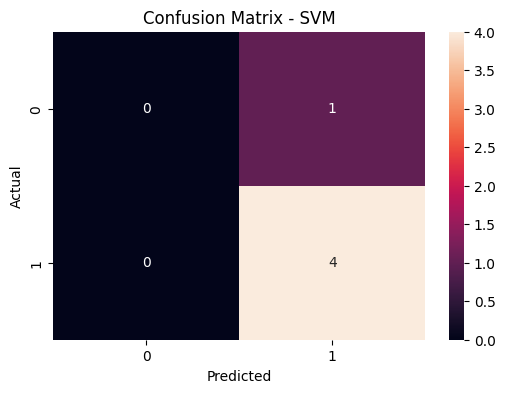

In [ ]:
# ===============================
# 7. Confusion Matrix
# ===============================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
correct = sum(y_test == y_pred)
total = len(y_test)

print(f" Akurasi SVM: {accuracy*100:.2f}%")
print(f" Benar: {correct} data")
print(f" Salah: {total - correct} data")
print(f" Total data uji: {total}")


 Akurasi SVM: 80.00%
 Benar: 4 data
 Salah: 1 data
 Total data uji: 5


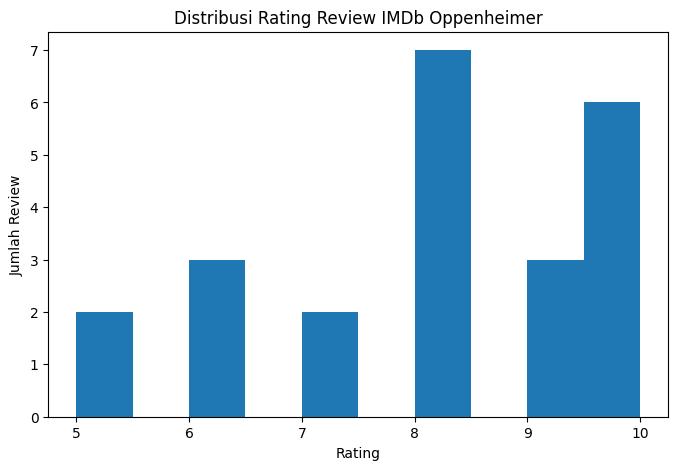

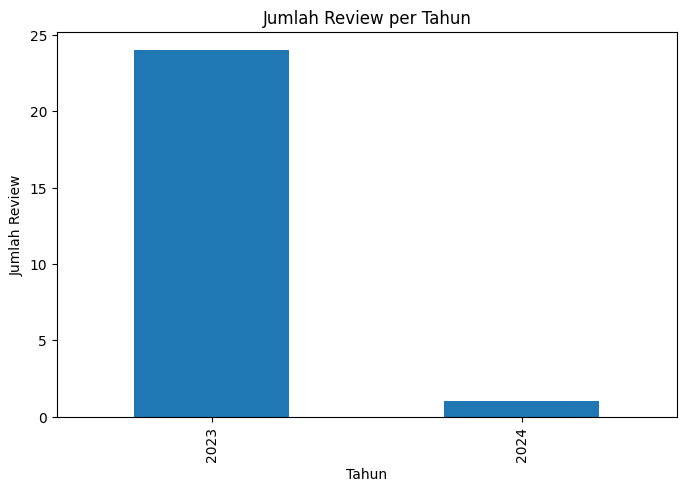

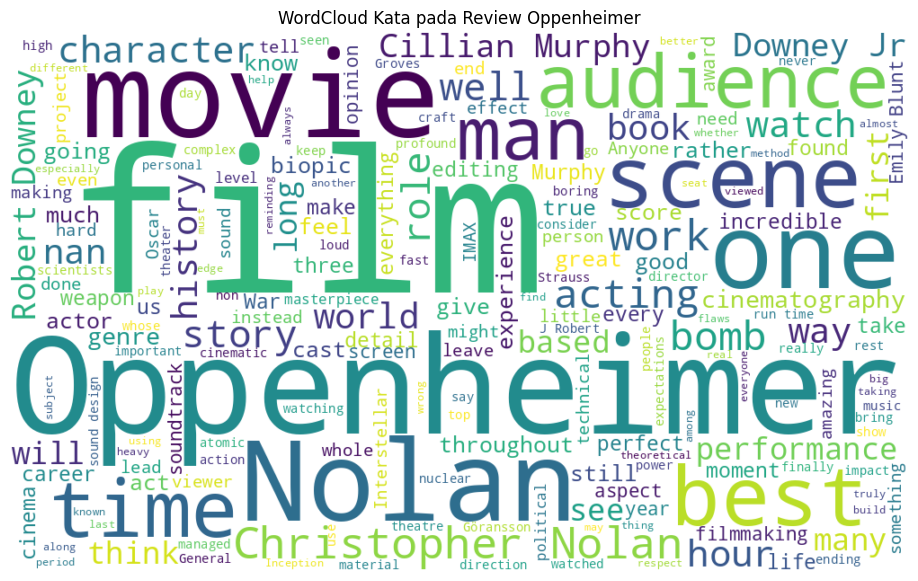

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Load dataset
df = pd.read_csv("oppenheimer_reviews_requests.csv")

# ----------------------------------
# 1️⃣ Distribusi Rating
# ----------------------------------
plt.figure(figsize=(8,5))
plt.hist(df['Rating'], bins=10)
plt.title("Distribusi Rating Review IMDb Oppenheimer")
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.show()

# ----------------------------------
# 2️⃣ Visualisasi Tren Review per Tahun
# ----------------------------------
df['Review_Date'] = pd.to_datetime(df['Review_Date'], errors='coerce')
df['Year'] = df['Review_Date'].dt.year

plt.figure(figsize=(8,5))
df['Year'].value_counts().sort_index().plot(kind='bar')
plt.title("Jumlah Review per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Review")
plt.show()

# ----------------------------------
# 3️⃣ WordCloud Review Text
# ----------------------------------
text_data = " ".join(df['Review_Text'].astype(str))

wordcloud = WordCloud(width=1000, height=600,
                      background_color='white').generate(text_data)

plt.figure(figsize=(12,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud Kata pada Review Oppenheimer")
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv("oppenheimer_reviews_requests.csv")
print(df.columns)
df.head()

Index(['Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title',
       'Review_Text'],
      dtype='object')


,Reviewer_Name,Review_Date,Rating,Review_Title,Review_Text
0,Orlando_Gardner,"Jul 18, 2023",9.0,Murphy is exceptional,NaN
1,Jeremy_Urquhart,"Jul 19, 2023",8.0,"A challenging watch to be sure, but a worthwhi...",NaN
2,Bonobo13579,"Jul 20, 2023",7.0,Quality but exhausting,I'm a big fan of Nolan's work so was really lo...
3,mark-217-307033,"Jul 18, 2023",10.0,And the Oscar goes to...,I'm still collecting my thoughts after experie...
4,MrDHWong,"Jul 19, 2023",10.0,A brilliantly layered examination of a man thr...,"""Oppenheimer"" is a biographical thriller film ..."


✅ Data berhasil dimuat!
     Reviewer_Name   Review_Date  Rating  \
0  Orlando_Gardner  Jul 18, 2023     9.0   
1  Jeremy_Urquhart  Jul 19, 2023     8.0   
2      Bonobo13579  Jul 20, 2023     7.0   
3  mark-217-307033  Jul 18, 2023    10.0   
4         MrDHWong  Jul 19, 2023    10.0   

                                        Review_Title  \
0                              Murphy is exceptional   
1  A challenging watch to be sure, but a worthwhi...   
2                             Quality but exhausting   
3                           And the Oscar goes to...   
4  A brilliantly layered examination of a man thr...   

                                         Review_Text  
0                                                NaN  
1                                                NaN  
2  I'm a big fan of Nolan's work so was really lo...  
3  I'm still collecting my thoughts after experie...  
4  "Oppenheimer" is a biographical thriller film ...   

📌 Kolom yang tersedia: ['Reviewer_Name', '

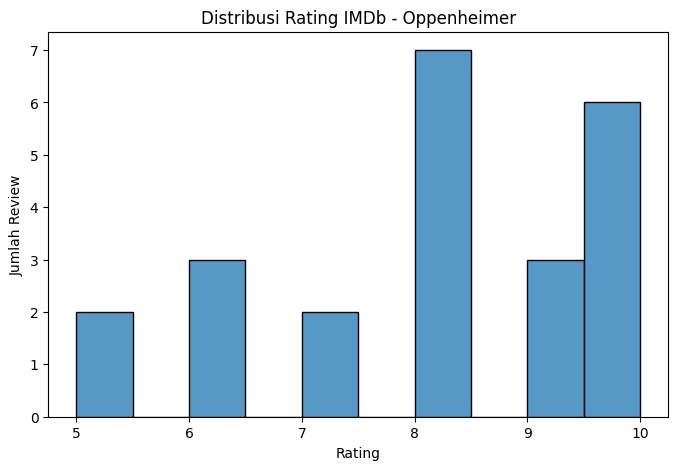

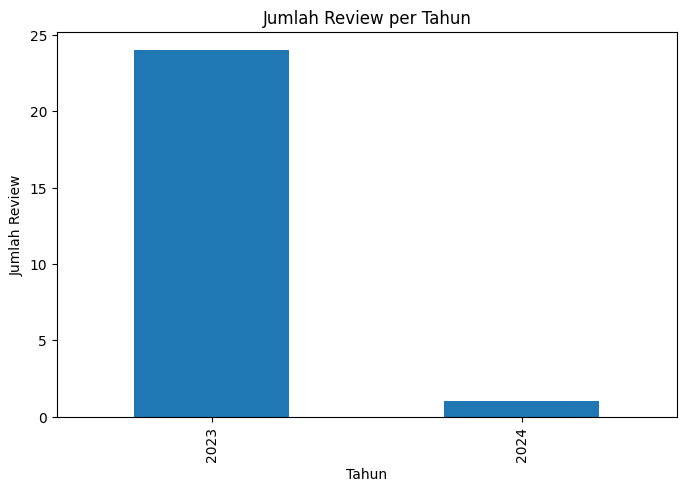

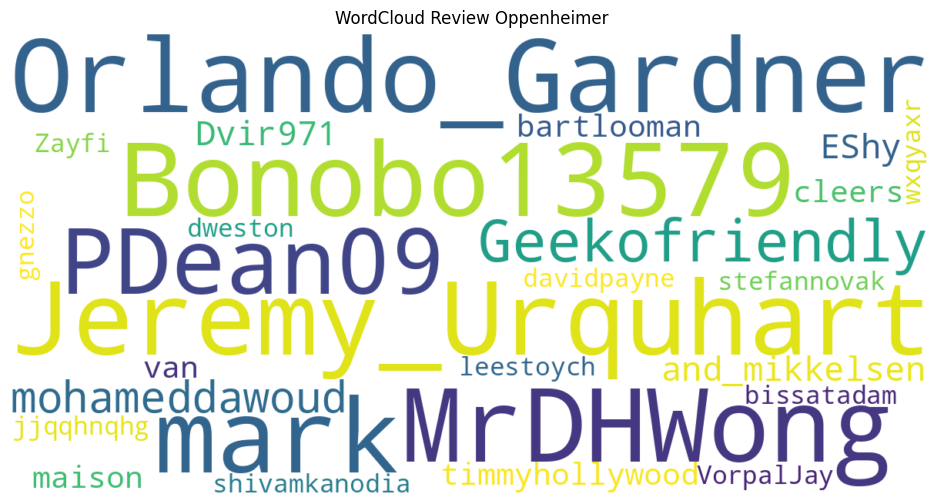

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# ================================
# Load Data
# ================================
df = pd.read_csv("oppenheimer_reviews_requests.csv")

print("✅ Data berhasil dimuat!")
print(df.head(), "\n")
print("📌 Kolom yang tersedia:", df.columns.tolist(), "\n")

# ================================
# Deteksi kolom otomatis
# ================================
reviewer_col = [c for c in df.columns if "reviewer" in c.lower()][0]
date_col = [c for c in df.columns if "date" in c.lower()][0]
rating_col = [c for c in df.columns if "rating" in c.lower()][0]
text_col = [c for c in df.columns if "review" in c.lower()][0]  # text review
title_col = [c for c in df.columns if "title" in c.lower()][0]

print("Kolom digunakan:")
print("- Reviewer:", reviewer_col)
print("- Date:", date_col)
print("- Rating:", rating_col)
print("- Title:", title_col)
print("- Review Text:", text_col, "\n")

# ================================
# Parsing Tanggal IMDb
# ================================
df[date_col] = pd.to_datetime(df[date_col], format="%b %d, %Y", errors="coerce")
df["Year"] = df[date_col].dt.year

print("✅ Parsing tanggal selesai")
print("Valid dates:", df[date_col].notna().sum())
print("Invalid dates:", df[date_col].isna().sum(), "\n")

# ================================
# Visualisasi 1: Distribusi Rating
# ================================
plt.figure(figsize=(8,5))
sns.histplot(df[rating_col], bins=10)
plt.title("Distribusi Rating IMDb - Oppenheimer")
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.grid(False)
plt.show()

# ================================
# Visualisasi 2: Review per Tahun
# ================================
if df["Year"].notna().sum() > 0:
    plt.figure(figsize=(8,5))
    df["Year"].value_counts().sort_index().plot(kind='bar')
    plt.title("Jumlah Review per Tahun")
    plt.xlabel("Tahun")
    plt.ylabel("Jumlah Review")
    plt.grid(False)
    plt.show()
else:
    print("⚠ Tidak ada data tahun yang valid untuk ditampilkan.")

# ================================
# Visualisasi 3: WordCloud
# ================================
text_data = " ".join(df[text_col].astype(str))
if len(text_data.strip()) > 0:
    wordcloud = WordCloud(width=1200, height=600, background_color="white").generate(text_data)

    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud Review Oppenheimer")
    plt.show()
else:
    print("⚠ Text review kosong, WordCloud tidak bisa dibentuk.")

Install Dependencies

In [ ]:
!pip install datasets transformers peft accelerate sentencepiece scikit-learn tensorflow torch


Import Library

In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model


Load Dataset (IMDB)

In [ ]:
dataset = load_dataset("imdb")
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]

test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

============================================

🔵 1. MODEL KLASIK (TF-IDF + NAIVE BAYES / SVM)

============================================



TF-IDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(train_texts)
X_test_tfidf = vectorizer.transform(test_texts)


Naive Bayes

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, train_labels)

nb_preds = nb.predict(X_test_tfidf)
print("Naive Bayes Accuracy:", accuracy_score(test_labels, nb_preds))
print(classification_report(test_labels, nb_preds))


Naive Bayes Accuracy: 0.84052
              precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.82      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



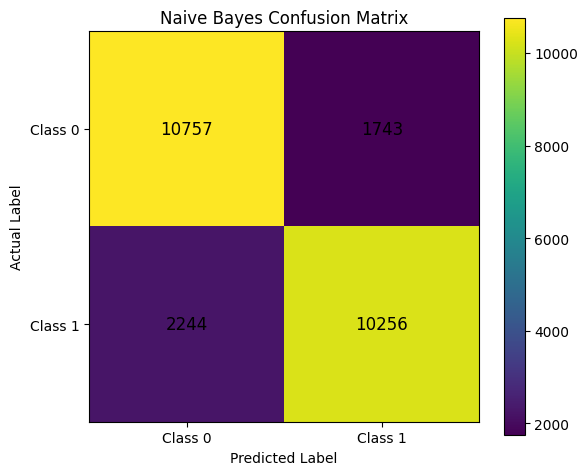

Gambar disimpan sebagai nb_confusion_matrix.png


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Hitung confusion matrix
cm = confusion_matrix(test_labels, nb_preds)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.xticks([0,1], ["Class 0", "Class 1"])
plt.yticks([0,1], ["Class 0", "Class 1"])

# Tambahkan angka dalam cell
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=12)

plt.colorbar()
plt.tight_layout()

# Simpan gambar
plt.savefig("nb_confusion_matrix.png", dpi=300, bbox_inches='tight')

# Tampilkan
plt.show()

print("Gambar disimpan sebagai nb_confusion_matrix.png")


SVM

In [ ]:
svm = LinearSVC()
svm.fit(X_train_tfidf, train_labels)

svm_preds = svm.predict(X_test_tfidf)
print("SVM Accuracy:", accuracy_score(test_labels, svm_preds))
print(classification_report(test_labels, svm_preds))


SVM Accuracy: 0.87128
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



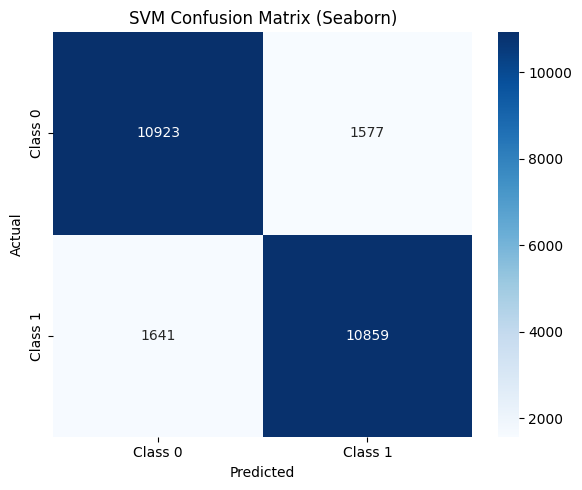

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, svm_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])

plt.title("SVM Confusion Matrix (Seaborn)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

plt.savefig("svm_confusion_matrix_seaborn.png", dpi=300, bbox_inches='tight')
plt.show()


============================================

🔵 2. DEEP LEARNING (LSTM Keras)

============================================

Tokenizing

In [ ]:
tokenizer_dl = Tokenizer(num_words=20000)
tokenizer_dl.fit_on_texts(train_texts)

X_train_seq = tokenizer_dl.texts_to_sequences(train_texts)
X_test_seq = tokenizer_dl.texts_to_sequences(test_texts)

X_train_padded = pad_sequences(X_train_seq, maxlen=200)
X_test_padded = pad_sequences(X_test_seq, maxlen=200)


Build LSTM Model

In [ ]:
model_lstm = Sequential([
    layers.Embedding(20000, 64, input_length=200),
    layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    layers.Dense(1, activation="sigmoid")
])

model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_lstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train LSTM

In [ ]:
history = model_lstm.fit(
    X_train_padded, np.array(train_labels),
    validation_split=0.2,
    epochs=2,
    batch_size=128
)


Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 170s 949ms/step - accuracy: 0.6611 - loss: 0.6055 - val_accuracy: 0.6804 - val_loss: 0.6713
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 116s 738ms/step - accuracy: 0.8541 - loss: 0.3551 - val_accuracy: 0.8678 - val_loss: 0.3690


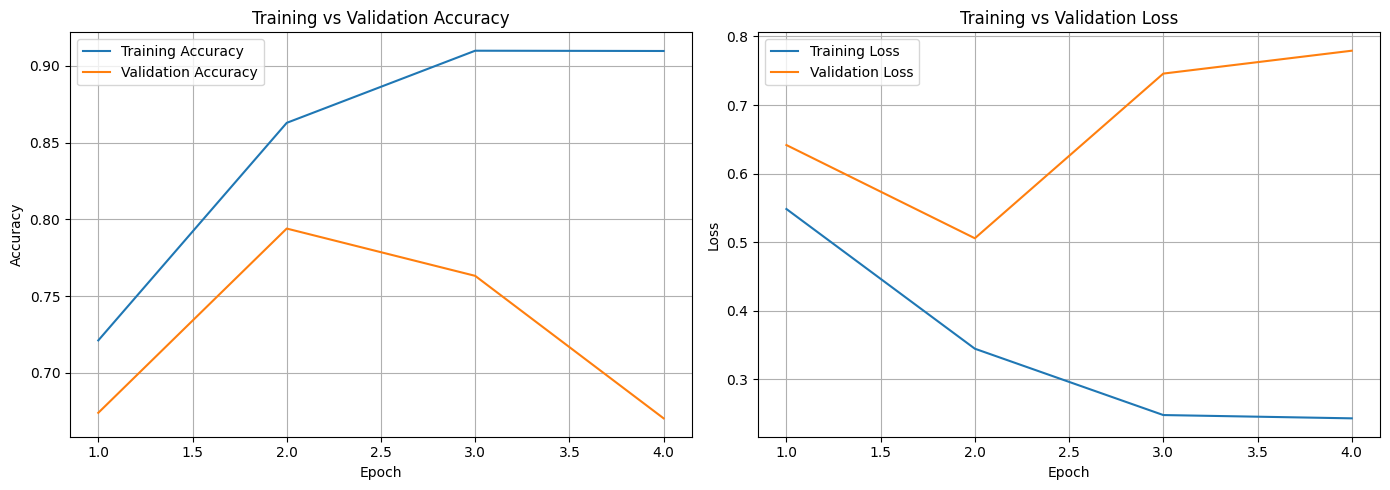

In [ ]:
import matplotlib.pyplot as plt

# Ambil history setelah training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))

# === Plot Accuracy (kiri) ===
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# === Plot Loss (kanan) ===
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Evaluate LSTM

In [ ]:
lstm_preds = (model_lstm.predict(X_test_padded) > 0.5).astype(int)
print("LSTM Accuracy:", accuracy_score(test_labels, lstm_preds))
print(classification_report(test_labels, lstm_preds))


782/782 ━━━━━━━━━━━━━━━━━━━━ 113s 144ms/step
LSTM Accuracy: 0.844
              precision    recall  f1-score   support

           0       0.87      0.81      0.84     12500
           1       0.82      0.88      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000



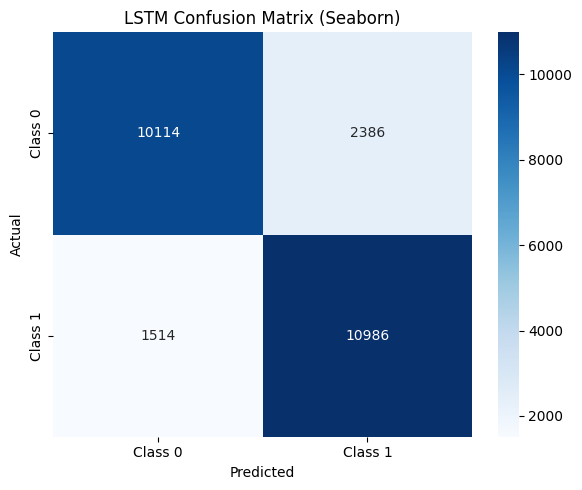

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, lstm_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])

plt.title("LSTM Confusion Matrix (Seaborn)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


============================================

🔵 3. TRANSFER LEARNING (DistilBERT)

============================================

Tokenizer

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Encode Data

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

encoded_train = dataset["train"].map(tokenize, batched=True)
encoded_test = dataset["test"].map(tokenize, batched=True)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Load DistilBERT Model

In [ ]:
bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Arguments

In [ ]:
args = TrainingArguments(
    output_dir="distilbert-finetuned-imdb",
    # evaluation_strategy="epoch", # Removed due to TypeError in current transformers version
    # save_strategy="epoch",       # Removed due to TypeError in current transformers version
    logging_dir="logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    fp16=True
)

trainer = Trainer(
    model=bert_model,
    args=args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
)

Fine-tune BERT

In [ ]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hafizgaming02 (hafizgaming02-informatica) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.428800
1000,0.341300
1500,0.331500
2000,0.297800
2500,0.288100
3000,0.272300


TrainOutput(global_step=3125, training_loss=0.3246784753417969, metrics={'train_runtime': 446.1837, 'train_samples_per_second': 56.031, 'train_steps_per_second': 7.004, 'total_flos': 1655842483200000.0, 'train_loss': 0.3246784753417969, 'epoch': 1.0})

Evaluate BERT

In [ ]:
bert_preds = trainer.predict(encoded_test)
bert_y = np.argmax(bert_preds.predictions, axis=1)

print("DistilBERT Accuracy:", accuracy_score(test_labels, bert_y))
print(classification_report(test_labels, bert_y))


DistilBERT Accuracy: 0.91144
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     12500
           1       0.91      0.91      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000



DistilBERT Accuracy: 0.91304
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     12500
           1       0.90      0.93      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000



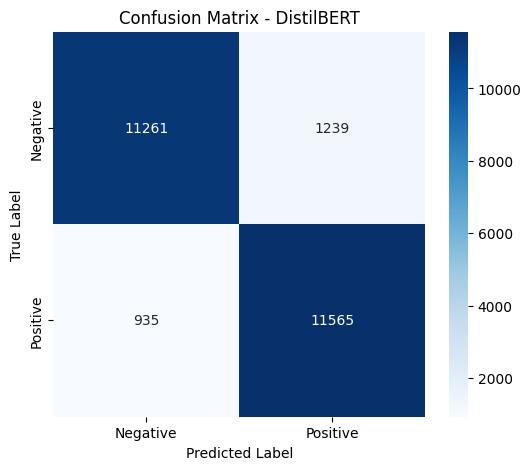

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# ======== Prediksi BERT ========
bert_preds = trainer.predict(encoded_test)
bert_y = np.argmax(bert_preds.predictions, axis=1)

print("DistilBERT Accuracy:", accuracy_score(test_labels, bert_y))
print(classification_report(test_labels, bert_y))

# ======== Confusion Matrix ========
cm_bert = confusion_matrix(test_labels, bert_y)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])

plt.title("Confusion Matrix - DistilBERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


============================================

🔵 4. LoRA (PEFT on DistilBERT)

============================================

Load Base Model

In [ ]:
lora_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Apply LoRA

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_lin", "k_lin", "v_lin"],
    lora_dropout=0.1,
    bias="none",
)

lora_model = get_peft_model(lora_model, lora_config)
lora_model.print_trainable_parameters()


trainable params: 221,184 || all params: 67,176,194 || trainable%: 0.3293


Train LoRA

In [ ]:
trainer_lora = Trainer(
    model=lora_model,
    args=TrainingArguments(
        output_dir="lora-distilbert-imdb",
        # evaluation_strategy="epoch", # Commented out due to TypeError
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=1,
        logging_dir="logs",
        fp16=True
    ),
    train_dataset=encoded_train,
    eval_dataset=encoded_test
)

trainer_lora.train()

Step,Training Loss
500,0.630500
1000,0.396400
1500,0.362600
2000,0.328600
2500,0.337900
3000,0.328500


TrainOutput(global_step=3125, training_loss=0.39389365600585935, metrics={'train_runtime': 173.4669, 'train_samples_per_second': 144.12, 'train_steps_per_second': 18.015, 'total_flos': 1664335948800000.0, 'train_loss': 0.39389365600585935, 'epoch': 1.0})

Evaluate LoRA

In [ ]:
lora_preds = trainer_lora.predict(encoded_test)
lora_y = np.argmax(lora_preds.predictions, axis=1)

print("LoRA Accuracy:", accuracy_score(test_labels, lora_y))
print(classification_report(test_labels, lora_y))


LoRA Accuracy: 0.87144
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



LoRA Accuracy: 0.87144
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



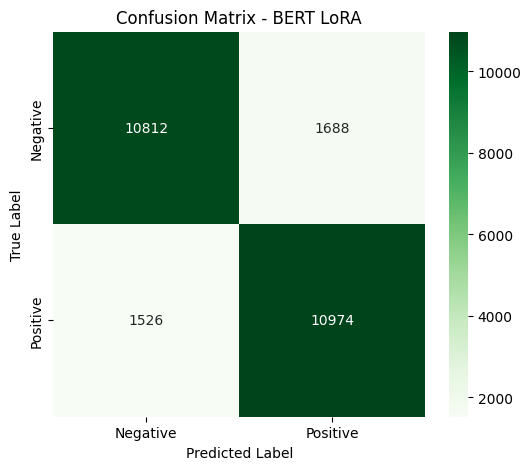

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# ======== Prediksi LoRA ========
lora_preds = trainer_lora.predict(encoded_test)
lora_y = np.argmax(lora_preds.predictions, axis=1)

print("LoRA Accuracy:", accuracy_score(test_labels, lora_y))
print(classification_report(test_labels, lora_y))

# ======== Confusion Matrix ========
cm_lora = confusion_matrix(test_labels, lora_y)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lora, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])

plt.title("Confusion Matrix - BERT LoRA")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


============================================

🔵 5. SIMPAN HASIL PERBANDINGAN

============================================

Simpan ke CSV

In [ ]:
results = {
    "Model": ["Naive Bayes", "SVM", "LSTM", "DistilBERT", "LoRA"],
    "Accuracy": [
        accuracy_score(test_labels, nb_preds),
        accuracy_score(test_labels, svm_preds),
        accuracy_score(test_labels, lstm_preds),
        accuracy_score(test_labels, bert_y),
        accuracy_score(test_labels, lora_y)
    ]
}

df_results = pd.DataFrame(results)
df_results.to_csv("comparison_results.csv", index=False)

df_results


,Model,Accuracy
0,Naive Bayes,0.84052
1,SVM,0.87128
2,LSTM,0.84400
3,DistilBERT,0.91144
4,LoRA,0.87144


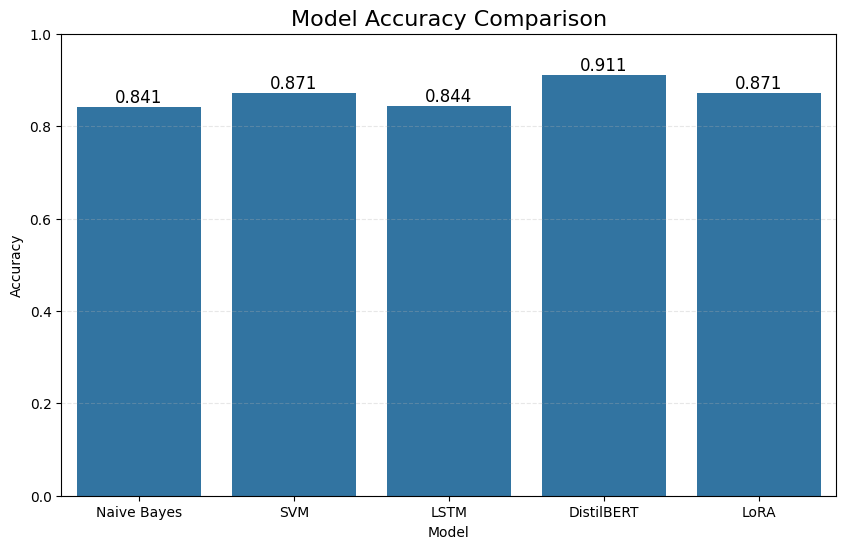

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Plot Accuracy Comparison ----
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Model", y="Accuracy")

plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # akurasi dalam range 0–1
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Menampilkan nilai akurasi di atas bar
for i, acc in enumerate(df_results["Accuracy"]):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center', fontsize=12)

plt.show()


 CELL (Imports & helper plotting / ROC)

In [ ]:
# tambahan imports
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from scipy.special import softmax
import time


CELL (Plot helpers)

In [ ]:
def plot_history(history, title_prefix='Model'):
    """
    history: keras History object or dict with keys 'loss','val_loss','accuracy','val_accuracy'
    """
    if hasattr(history, 'history'):
        h = history.history
    else:
        h = history
    epochs = range(1, len(h['loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'], label='train_loss')
    if 'val_loss' in h:
        plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch'); plt.legend()

    plt.subplot(1,2,2)
    if 'accuracy' in h:
        plt.plot(epochs, h['accuracy'], label='train_acc')
    if 'val_accuracy' in h:
        plt.plot(epochs, h['val_accuracy'], label='val_acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch'); plt.legend()
    plt.show()

def plot_roc(y_true, y_score, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc


============================================

A. CLASSICAL — Hyperparameter tuning + ROC

============================================

CELL (GridSearch untuk NB & SVM)

Starting GridSearch (NB & SVM) — this may take a few minutes
Best NB: {'alpha': 0.01} score: 0.843968922299637
Best SVM: {'C': 0.1} score: 0.8658620382559762


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


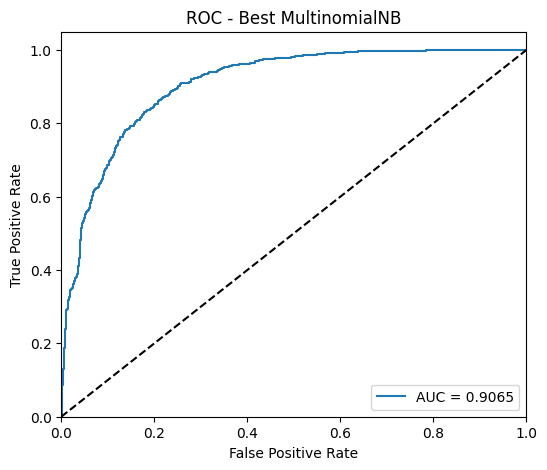

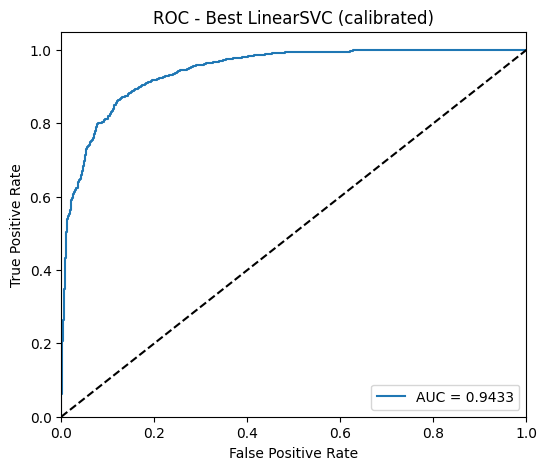

NB AUC: 0.9065179999999999 SVM AUC: 0.943277


In [ ]:
# Grid search untuk MultinomialNB & LinearSVC (cepat subsample agar cepat)
from sklearn.model_selection import StratifiedKFold, train_test_split

# gunakan subset lebih kecil agar cepat (misal 10000 train / 2000 test)
sub_n = 10000
sub_m = 2000

# Create a stratified subsample for training GridSearch
X_sub_train, _, y_sub_train, _ = train_test_split(
    list(train_texts), list(train_labels), train_size=sub_n, stratify=list(train_labels), random_state=42
)
X = X_sub_train
y = y_sub_train

# For testing, directly take a stratified subsample
X_test_sub, _, y_test_sub, _ = train_test_split(
    list(test_texts), list(test_labels), train_size=sub_m, stratify=list(test_labels), random_state=42
)

tf = TfidfVectorizer(max_features=5000)
X_tfidf = tf.fit_transform(X)
X_test_tfidf_sub = tf.transform(X_test_sub)

print("Starting GridSearch (NB & SVM) — this may take a few minutes")

# MultinomialNB
params_nb = {'alpha': [0.01, 0.1, 0.5, 1.0]}
gs_nb = GridSearchCV(MultinomialNB(), params_nb, cv=3, scoring='f1', n_jobs=-1)
gs_nb.fit(X_tfidf, y)
print("Best NB:", gs_nb.best_params_, "score:", gs_nb.best_score_)
best_nb = gs_nb.best_estimator_

# SVM (use CalibratedClassifier for probabilities)
params_svm = {'C': [0.01, 0.1, 1.0]}
gs_svm = GridSearchCV(LinearSVC(max_iter=10000), params_svm, cv=3, scoring='f1', n_jobs=-1)
gs_svm.fit(X_tfidf, y)
print("Best SVM:", gs_svm.best_params_, "score:", gs_svm.best_score_)
best_svm_raw = gs_svm.best_estimator_
# wrap SVM with CalibratedClassifierCV to get probabilities for ROC
best_svm = CalibratedClassifierCV(best_svm_raw, cv='prefit')
best_svm.fit(X_tfidf, y)

# evaluate on subsampled test
y_nb_prob = best_nb.predict_proba(X_test_tfidf_sub)[:,1]
y_svm_prob = best_svm.predict_proba(X_test_tfidf_sub)[:,1]

nb_auc = plot_roc(y_test_sub, y_nb_prob, title='ROC - Best MultinomialNB')
svm_auc = plot_roc(y_test_sub, y_svm_prob, title='ROC - Best LinearSVC (calibrated)')
print("NB AUC:", nb_auc, "SVM AUC:", svm_auc)


============================================

B. LSTM — training plots, ROC, hyperparam search (simple)

============================================


CELL (Train LSTM with history plotting & ROC)

Epoch 1/4
176/176 ━━━━━━━━━━━━━━━━━━━━ 148s 821ms/step - accuracy: 0.8840 - loss: 0.3042 - val_accuracy: 0.7060 - val_loss: 0.7535
Epoch 2/4
176/176 ━━━━━━━━━━━━━━━━━━━━ 131s 745ms/step - accuracy: 0.9075 - loss: 0.2438 - val_accuracy: 0.7700 - val_loss: 0.5675
Epoch 3/4
176/176 ━━━━━━━━━━━━━━━━━━━━ 131s 745ms/step - accuracy: 0.9260 - loss: 0.2040 - val_accuracy: 0.7420 - val_loss: 0.6830
Epoch 4/4
176/176 ━━━━━━━━━━━━━━━━━━━━ 131s 743ms/step - accuracy: 0.9270 - loss: 0.2043 - val_accuracy: 0.7072 - val_loss: 0.8218


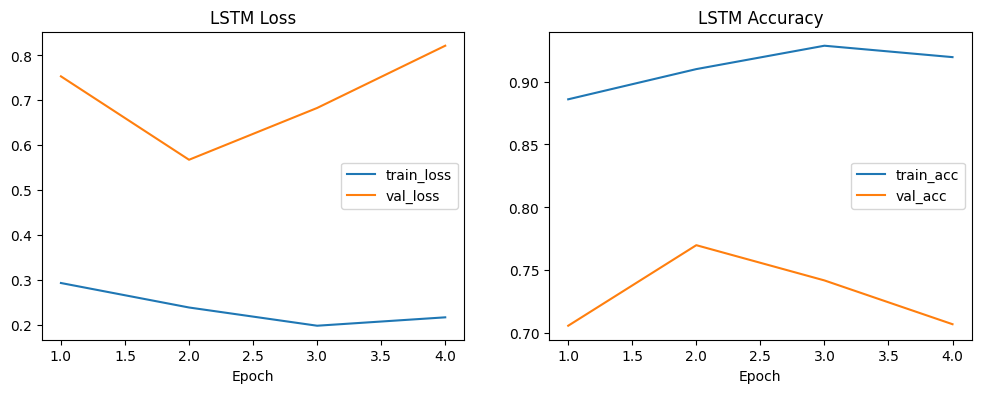

782/782 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step


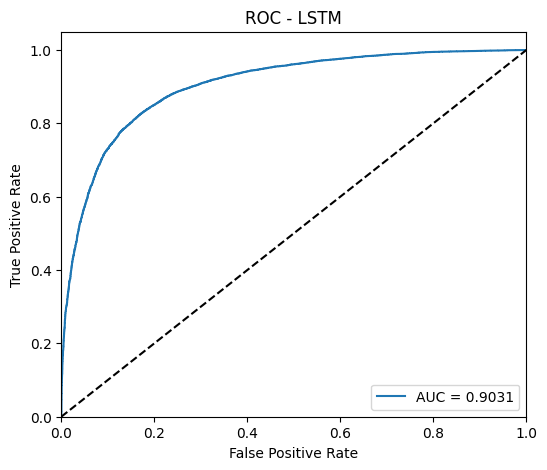

LSTM AUC: 0.9031070464


In [ ]:
# we already have tokenizer_dl, X_train_padded, X_test_padded, train_labels, test_labels
# If you restarted runtime, re-run tokenizing cell above.

# Train LSTM (if model already exists from earlier cell, skip training and use 'history' from above)
history = model_lstm.fit(
    X_train_padded, np.array(train_labels),
    validation_split=0.1,
    epochs=4,
    batch_size=128
)

# Plot loss & acc
plot_history(history, title_prefix='LSTM')

# ROC-AUC: need probabilities
y_prob_lstm = model_lstm.predict(X_test_padded).flatten()
lstm_auc = plot_roc(test_labels, y_prob_lstm, title='ROC - LSTM')
print("LSTM AUC:", lstm_auc)


CELL (Simple grid search for LSTM hyperparams — quick demo)

Testing config: {'embedding_dim': 64, 'lstm_units': 64, 'dropout': 0.2}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Val acc: 1.0
Testing config: {'embedding_dim': 128, 'lstm_units': 64, 'dropout': 0.2}
Val acc: 1.0
Testing config: {'embedding_dim': 64, 'lstm_units': 128, 'dropout': 0.3}
Val acc: 1.0
Best LSTM quick config: {'embedding_dim': 64, 'lstm_units': 64, 'dropout': 0.2} val_acc: 1.0


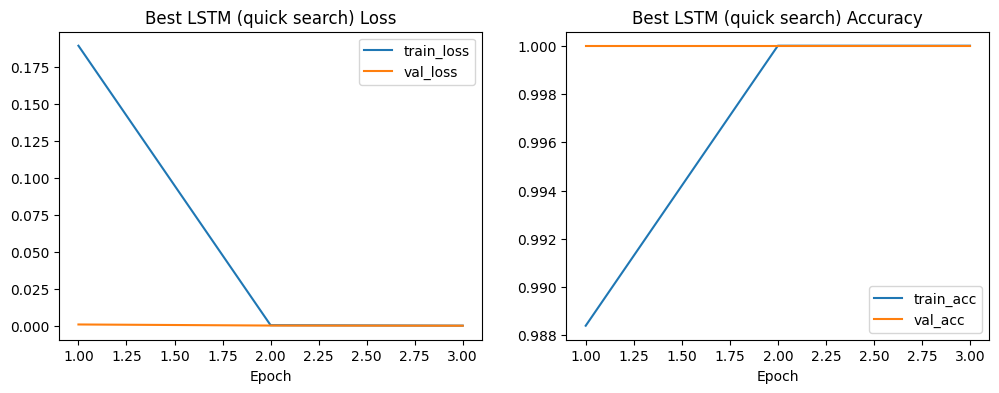

In [ ]:
# Quick coarse grid search for small number of combos to keep runtime reasonable
param_grid = [
    {'embedding_dim':64, 'lstm_units':64, 'dropout':0.2},
    {'embedding_dim':128, 'lstm_units':64, 'dropout':0.2},
    {'embedding_dim':64, 'lstm_units':128, 'dropout':0.3},
]

best = {'config': None, 'val_acc': 0.0}
# use small subset to speed up
n_train_quick = 5000
Xq = X_train_padded[:n_train_quick]
yq = np.array(train_labels)[:n_train_quick]
Xq_val = X_train_padded[n_train_quick:n_train_quick+1000]
yq_val = np.array(train_labels)[n_train_quick:n_train_quick+1000]

for cfg in param_grid:
    print("Testing config:", cfg)
    tf.keras.backend.clear_session()
    m = Sequential([
        layers.Embedding(20000, cfg['embedding_dim'], input_length=200),
        layers.SpatialDropout1D(cfg['dropout']),
        layers.LSTM(cfg['lstm_units']),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    h = m.fit(Xq, yq, validation_data=(Xq_val,yq_val), epochs=3, batch_size=128, verbose=0)
    val_acc = h.history['val_accuracy'][-1]
    print("Val acc:", val_acc)
    if val_acc > best['val_acc']:
        best = {'config': cfg, 'val_acc': val_acc, 'model': m, 'history': h}
print("Best LSTM quick config:", best['config'], "val_acc:", best['val_acc'])
plot_history(best['history'], title_prefix='Best LSTM (quick search)')


============================================

C. DistilBERT / LoRA — training history, ROC, simple hyperparam search

============================================

CELL (compute metrics + helper for Trainer to compute ROC/AUC)

In [ ]:
# helper compute_metrics that includes AUC
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

def compute_metrics_with_auc(eval_pred):
    logits, labels = eval_pred
    probs = softmax(logits, axis=1)[:,1]  # prob of positive class
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    try:
        auc_score = roc_auc_score(labels, probs)
    except Exception as e:
        auc_score = 0.0
    return {'accuracy': float(acc), 'precision': float(prec), 'recall': float(rec), 'f1': float(f1), 'roc_auc': float(auc_score)}


In [ ]:
# -----------------------------
# 2) Imports
# -----------------------------
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt


# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks


# Transformers / Datasets
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
TrainingArguments, Trainer, DataCollatorWithPadding)


# PEFT (LoRA)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training


# Suppress warnings
import logging
logging.basicConfig(level=logging.INFO)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3159153710.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


Step,Training Loss
500,0.421200
1000,0.360300
1500,0.334200
2000,0.304700
2500,0.292400
3000,0.269000


Eval metrics: {'eval_loss': 0.25745657086372375, 'eval_accuracy': 0.9114, 'eval_precision': 0.9132845776741944, 'eval_recall': 0.90912, 'eval_f1': 0.9111975303692419, 'eval_roc_auc': 0.9702567199999999, 'eval_runtime': 50.106, 'eval_samples_per_second': 498.942, 'eval_steps_per_second': 31.194, 'epoch': 1.0}


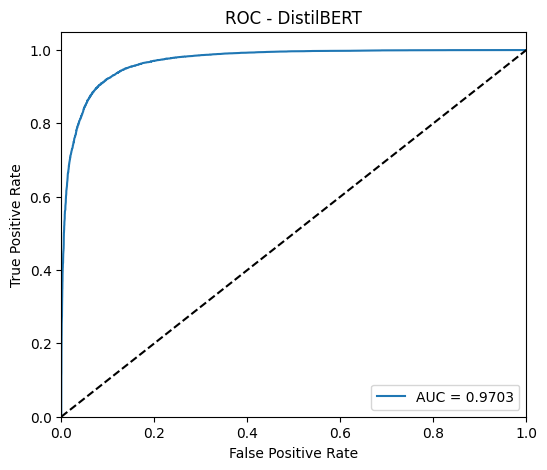

DistilBERT AUC: 0.9702567199999999


In [ ]:
# If you haven't loaded/defined model_name/tokenizer/encoded_train/encoded_test, run the earlier cells to prepare them.
# Re-load model and create trainer with compute_metrics_with_auc
bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Ensure the correct tokenizer is used, especially if 'tokenizer' was overwritten by Keras's Tokenizer
hf_tokenizer = AutoTokenizer.from_pretrained(model_name)

args = TrainingArguments(
    output_dir="distilbert-finetuned-imdb",
    # evaluation_strategy="epoch", # Commented out due to TypeError
    # save_strategy="epoch",       # Commented out due to TypeError
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=1, # quick demo
    logging_dir="logs",
    fp16=torch.cuda.is_available()
)

trainer = Trainer(
    model=bert_model,
    args=args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=hf_tokenizer, # Use hf_tokenizer to avoid conflict
    compute_metrics=compute_metrics_with_auc
)

trainer.train()
res = trainer.evaluate()
print("Eval metrics:", res)

# Get logits from trainer.predict
preds = trainer.predict(encoded_test)
logits = preds.predictions
probs = softmax(logits, axis=1)[:,1]
bert_auc = plot_roc(test_labels, probs, title='ROC - DistilBERT')
print("DistilBERT AUC:", bert_auc)

In [ ]:
# -----------------------------
# 3) Load dataset
# -----------------------------
# Option A: Load HuggingFace IMDB dataset (works in Colab)
use_hf_imdb = True


if use_hf_imdb:
    print("Loading IMDB dataset from HuggingFace datasets...")
    raw_datasets = load_dataset('imdb') # train/test
    # convert to pandas for classical/deep models
    train_df = pd.DataFrame({
    'text': raw_datasets['train']['text'],
    'label': raw_datasets['train']['label']
    })
    test_df = pd.DataFrame({
    'text': raw_datasets['test']['text'],
    'label': raw_datasets['test']['label']
    })
else:
    # Option B: load local CSV with columns 'text' and 'label'
    df = pd.read_csv('reviews.csv')
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])


print('Train size:', len(train_df), 'Test size:', len(test_df))

Loading IMDB dataset from HuggingFace datasets...
Train size: 25000 Test size: 25000


In [ ]:
# -----------------------------
# 4) Preprocessing helpers
# -----------------------------


def print_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    print(f"Accuracy: {acc:.4f} Precision: {prec:.4f} Recall: {rec:.4f} F1: {f1:.4f}")
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

In [ ]:
# -----------------------------
# 5) Classical ML: TF-IDF + NB / SVM
# -----------------------------
print('\n--- Classical ML: TF-IDF + MultinomialNB / LinearSVC ---')


tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(train_df['text'].values)
X_test_tfidf = tfidf.transform(test_df['text'].values)
y_train = train_df['label'].values
y_test = test_df['label'].values


# Multinomial Naive Bayes
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
metrics_nb = print_metrics(y_test, y_pred_nb)


# Linear SVM
svm = LinearSVC(max_iter=10000)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)
metrics_svm = print_metrics(y_test, y_pred_svm)


classical_results = {'MultinomialNB': metrics_nb, 'LinearSVC': metrics_svm}


--- Classical ML: TF-IDF + MultinomialNB / LinearSVC ---
Accuracy: 0.8476 Precision: 0.8650 Recall: 0.8238 F1: 0.8439
Accuracy: 0.8728 Precision: 0.8808 Recall: 0.8622 F1: 0.8714


In [ ]:
# -----------------------------
# 6) Deep Learning: Keras Embedding + LSTM
# -----------------------------
print('\n--- Deep Learning: Keras Embedding + LSTM ---')


# Tokenize using Keras Tokenizer
max_words = 30000
maxlen = 256
embedding_dim = 128


tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'].values)


X_train_seq = tokenizer.texts_to_sequences(train_df['text'].values)
X_test_seq = tokenizer.texts_to_sequences(test_df['text'].values)


X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')


# Model
model = models.Sequential([
layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen),
layers.SpatialDropout1D(0.2),
layers.Bidirectional(layers.LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.1)),
layers.Dense(64, activation='relu'),
layers.Dropout(0.2),
layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


es = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


history = model.fit(
X_train_pad, y_train,
validation_split=0.1,
epochs=5,
batch_size=128,
callbacks=[es]
)


# Evaluate
y_prob_dl = model.predict(X_test_pad, batch_size=256)
y_pred_dl = (y_prob_dl.flatten() >= 0.5).astype(int)
metrics_dl = print_metrics(y_test, y_pred_dl)


deep_results = {'LSTM': metrics_dl}


--- Deep Learning: Keras Embedding + LSTM ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.6389 - loss: 0.6219 - val_accuracy: 0.6740 - val_loss: 0.6416
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.8406 - loss: 0.3836 - val_accuracy: 0.7940 - val_loss: 0.5056
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9009 - loss: 0.2667 - val_accuracy: 0.7632 - val_loss: 0.7459
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.8821 - loss: 0.3057 - val_accuracy: 0.6704 - val_loss: 0.7792
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 303ms/step
Accuracy: 0.8442 Precision: 0.8506 Recall: 0.8351 F1: 0.8428


In [ ]:
# -----------------------------
# 7) Transfer learning: fine-tune DistilBERT (HuggingFace Trainer)
# -----------------------------
# Install the missing 'evaluate' library
!pip install evaluate

print('\n--- Transfer Learning: DistilBERT fine-tune ---')


model_name = 'distilbert-base-uncased'


# Tokenizer and model
hf_tokenizer = AutoTokenizer.from_pretrained(model_name)


# Prepare dataset in HF format
hf_train = raw_datasets['train'].shuffle(seed=42).select(range(20000)) # use subset to speed up
hf_test = raw_datasets['test'].shuffle(seed=42).select(range(5000))


# Tokenize function


def tokenize_function(examples):
    return hf_tokenizer(examples['text'], truncation=True, max_length=256)


hf_train_tok = hf_train.map(tokenize_function, batched=True)
hf_test_tok = hf_test.map(tokenize_function, batched=True)


# Set format
hf_train_tok = hf_train_tok.remove_columns(['text']).with_format('torch')
hf_test_tok = hf_test_tok.remove_columns(['text']).with_format('torch')


# Load model
hf_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


# Training args (small for demo)
training_args = TrainingArguments(
    output_dir='./results-distilbert',
    # evaluation_strategy='epoch', # Removed due to TypeError in current transformers version
    # save_strategy='epoch',       # Removed due to TypeError in current transformers version
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    logging_steps=100,
    fp16=False
)


data_collator = DataCollatorWithPadding(tokenizer=hf_tokenizer)


# Define compute_metrics
import evaluate
metric = evaluate.load('accuracy')


def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}


trainer = Trainer(
    model=hf_model,
    args=training_args,
    train_dataset=hf_train_tok,
    eval_dataset=hf_test_tok,
    tokenizer=hf_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


trainer.train()
res = trainer.evaluate()
transfer_results = {'DistilBERT': res}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00

--- Transfer Learning: DistilBERT fine-tune ---


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-1856139606.py:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.432900
200,0.377100
300,0.313800
400,0.329800
500,0.317300
600,0.300000
700,0.281000
800,0.295800
900,0.250100
1000,0.272500


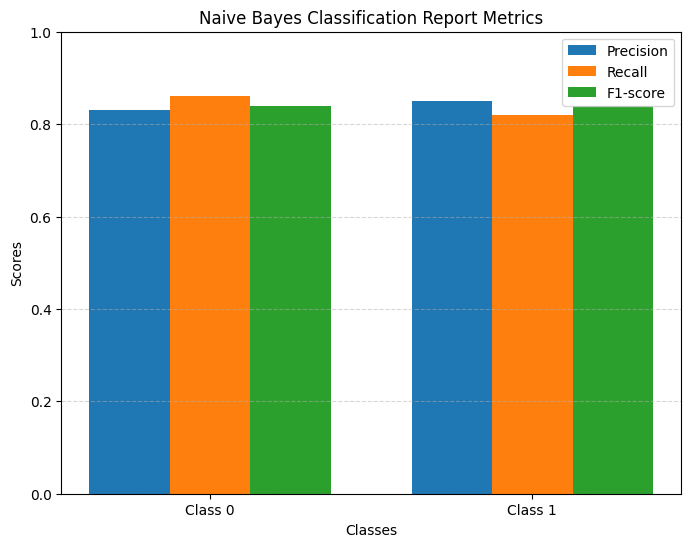

Gambar berhasil disimpan sebagai: naive_bayes_metrics.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === METRICS DARI HASIL NAIVE BAYES ===
classes = ['Class 0', 'Class 1']
precision = [0.83, 0.85]
recall = [0.86, 0.82]
f1 = [0.84, 0.84]

# === POSISI BAR ===
x = np.arange(len(classes))
width = 0.25

# === FIGURE ===
plt.figure(figsize=(8,6))

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Naive Bayes Classification Report Metrics')
plt.xticks(x, classes)
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# === SIMPAN GAMBAR ===
plt.savefig("naive_bayes_metrics.png", dpi=300, bbox_inches='tight')

# === TAMPILKAN DI COLAB ===
plt.show()

print("Gambar berhasil disimpan sebagai: naive_bayes_metrics.png")
